In [ ]:
import os
import time
import json
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from data.trajectory_loader import load_and_concat_flights
from models.attention_gru_predictor import TrajPredictor
from utils.logger import get_logger

In [24]:
# --- Parameters ---
LOOK_BACK = 50
FORWARD_LEN = 5
CSV_PATH = "data/flights.csv"
BATCH_SIZE = 32
EPOCHS = 500
LEARNING_RATE = 1e-3
AGENTS = 3  # Number of agents in the trajectory data

In [25]:
# --- Setup logger and experiment folder ---
logger, exp_dir = get_logger()
os.makedirs(exp_dir, exist_ok=True)

logger.info("Experiment started")
logger.info("Experiment folder: %s", exp_dir)

2025-09-17 16:07:18,794 - INFO - Experiment started
2025-09-17 16:07:18,795 - INFO - Experiment folder: experiments/20250917_160718


In [26]:
# --- Load DataFrame ---
df = load_and_concat_flights(
    CSV_PATH,
    min_rows=800,
    num_flights=AGENTS,
    add_zurich_csv=True,
    zurich_csv_path="data/zurich_flights_downsampled_2.csv",
)

print(df.tail())

# --- Prepare sequences ---
X, y, trajectory_ids = [], [], []

for traj_idx in df["trajectory_index"].unique():
    traj_df = df[df["trajectory_index"] == traj_idx].reset_index(drop=True)

    # Drop trajectory_index for features
    traj_data = traj_df.drop(columns=["trajectory_index"]).values.astype(np.float32)
    n_rows = traj_data.shape[0]

    seq_count = n_rows - LOOK_BACK - FORWARD_LEN + 1
    for i in range(seq_count):
        seq_X = traj_data[i : i + LOOK_BACK]  # shape (LOOK_BACK, features)
        seq_y = traj_data[i + LOOK_BACK + FORWARD_LEN - 1]  # shape (features,)

        X.append(seq_X)
        y.append(seq_y)
        trajectory_ids.append(traj_idx)


/Users/aungmyinmoe/Documents/Temasek Labs/Multi_Drone_Prediction/data/trajectory_loader.py:48: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


['Timpstemp', 'imgid', 'lat', 'lon', 'alt', 's_variance_m_s', 'c_variance_rad', 'fix_type', 'eph_m', 'epv_m', 'vel_n_m_s', 'vel_e_m_s', 'vel_d_m_s', 'num_sat', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'time_s']
        position_x_flight1  position_y_flight1  position_z_flight1  \
237300           55.247571         -215.726041             472.659   
237301           55.383241         -215.659250             472.611   
237302           55.383241         -215.659250             472.611   
237303           55.503836         -215.648118             472.720   
237304           55.503836         -215.648118             472.720   

        position_x_flight2  position_y_flight2  position_z_flight2  \
237300          113.608000         -172.188988             478.458   
237301          113.743670         -172.022009             478.378   
237302          113.743670         -172.022009             478.378   
237303          113.894414         -171.888426             478.374   

In [27]:
# --- Convert to NumPy arrays ---
X = np.array(X, dtype=np.float32)  # (num_sequences, LOOK_BACK, features)
y = np.array(y, dtype=np.float32)  # (num_sequences, features)
trajectory_ids = np.array(trajectory_ids)

# --- Split train/test ---
X_train, X_test, y_train, y_test, traj_train, traj_test = train_test_split(
    X, y, trajectory_ids, test_size=0.2, shuffle=False
)

num_features_X = X_train.shape[-1]

# --- Scale column by column (concise approach) ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(X_train.reshape(-1, num_features_X))
X_train_scaled = scaler_X.transform(X_train.reshape(-1, num_features_X)).reshape(
    X_train.shape
)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, num_features_X)).reshape(
    X_test.shape
)

scaler_y.fit(y_train)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# --- Convert to tensors ---
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# --- Create DataLoaders ---
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False
)

In [28]:
# --- Log dataset sizes ---
total_sequences = X_train_tensor.shape[0] + X_test_tensor.shape[0]
logger.info("Total sequences: %d", total_sequences)
logger.info("Train sequences: %s", X_train_tensor.shape)
logger.info("Test sequences: %s", X_test_tensor.shape)

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info("Using device: %s", device)

2025-09-17 16:07:20,738 - INFO - Total sequences: 224777
2025-09-17 16:07:20,739 - INFO - Train sequences: torch.Size([179821, 50, 9])
2025-09-17 16:07:20,740 - INFO - Test sequences: torch.Size([44956, 50, 9])
2025-09-17 16:07:20,740 - INFO - Using device: cpu


In [29]:
# --- Model, criterion, optimizer ---
model_params = {
    "input_size": X_train_tensor.shape[-1],  # features (e.g., 3 for x,y,z)
    "hidden_size": 64,
    "output_size": y_train_tensor.shape[-1],  # same as features
    "num_layers": 1,
}

model = TrajPredictor(**model_params).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

logger.info("Model initialized:\n%s", model)

2025-09-17 16:07:20,747 - INFO - Model initialized:
TrajPredictor(
  (encoder): GRU(9, 64, batch_first=True)
  (decoder): GRU(9, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=9, bias=True)
)


In [30]:
# --- Training ---
patience = 15
best_loss = float("inf")
epochs_no_improve = 0
training_start = time.time()

try:
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0.0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        logger.info("Epoch %d/%d - Train Loss: %.7f", epoch + 1, EPOCHS, avg_loss)

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(exp_dir, "best_model.pt"))
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            logger.info("Early stopping triggered after %d epochs", epoch + 1)
            break

except KeyboardInterrupt:
    logger.warning("Training interrupted by user! Running evaluation...")

# --- Save last-epoch model ---
finally:
    torch.save(model.state_dict(), os.path.join(exp_dir, "last_model.pt"))
    logger.info("Training completed in %.2f seconds", time.time() - training_start)

2025-09-17 16:07:58,896 - INFO - Epoch 1/500 - Train Loss: 0.0008490
2025-09-17 16:08:34,827 - INFO - Epoch 2/500 - Train Loss: 0.0000311
2025-09-17 16:09:08,539 - INFO - Epoch 3/500 - Train Loss: 0.0000207
2025-09-17 16:09:41,951 - INFO - Epoch 4/500 - Train Loss: 0.0000151
2025-09-17 16:10:15,237 - INFO - Epoch 5/500 - Train Loss: 0.0000118
2025-09-17 16:10:48,496 - INFO - Epoch 6/500 - Train Loss: 0.0000095
2025-09-17 16:11:21,604 - INFO - Epoch 7/500 - Train Loss: 0.0000077
2025-09-17 16:11:57,359 - INFO - Epoch 8/500 - Train Loss: 0.0000069
2025-09-17 16:12:33,222 - INFO - Epoch 9/500 - Train Loss: 0.0000063
2025-09-17 16:13:07,615 - INFO - Epoch 10/500 - Train Loss: 0.0000059
2025-09-17 16:13:42,065 - INFO - Epoch 11/500 - Train Loss: 0.0000055
2025-09-17 16:14:16,241 - INFO - Epoch 12/500 - Train Loss: 0.0000054
2025-09-17 16:14:49,308 - INFO - Epoch 13/500 - Train Loss: 0.0000052
2025-09-17 16:15:22,427 - INFO - Epoch 14/500 - Train Loss: 0.0000049
2025-09-17 16:15:55,554 - INF

In [31]:
# --- Evaluation ---
model.eval()
all_preds, all_trues = [], []
inference_times = []
total_sequences = 0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        total_sequences += batch_x.size(0)

        start_time = time.time()
        outputs = model(batch_x)
        inference_times.append(time.time() - start_time)

        all_preds.append(outputs.cpu())
        all_trues.append(batch_y.cpu())

# Concatenate all batches
y_pred = torch.cat(all_preds, dim=0)
y_true = torch.cat(all_trues, dim=0)

# Inference time
total_inf_time = sum(inference_times)
logger.info(
    "Average inference time per sequence: %.6f s", total_inf_time / total_sequences
)
logger.info(
    "Average inference time per batch: %.6f s", total_inf_time / len(test_loader)
)

2025-09-17 17:48:43,797 - INFO - Average inference time per sequence: 0.000061 s
2025-09-17 17:48:43,798 - INFO - Average inference time per batch: 0.001950 s


In [32]:
# Save config / hyperparameters
config = {
    "device": str(device),
    "model_params": model_params,
    "LOOK_BACK": LOOK_BACK,
    "FORWARD_LEN": FORWARD_LEN,
    "EPOCHS": EPOCHS,
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
}

config_path = os.path.join(exp_dir, "config.json")
with open(config_path, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=4)

logger.info("Config saved to %s", config_path)

2025-09-17 17:48:45,347 - INFO - Config saved to experiments/20250917_160718/config.json


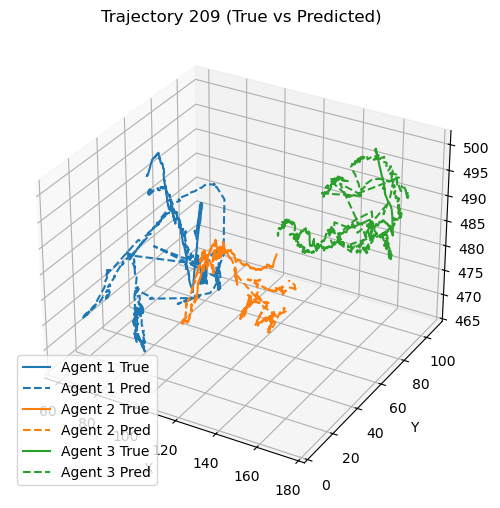

2025-09-17 17:51:47,036 - INFO - Plotted trajectory 209


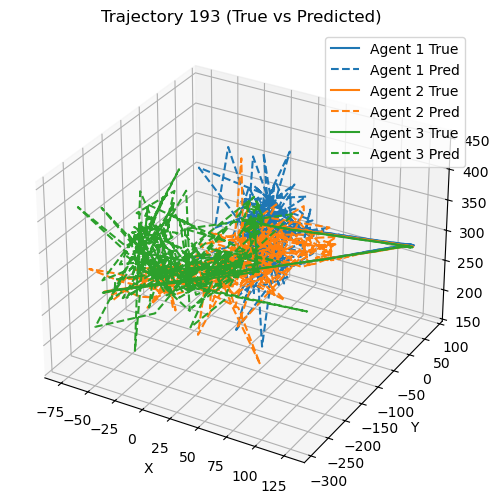

2025-09-17 17:51:47,283 - INFO - Plotted trajectory 193


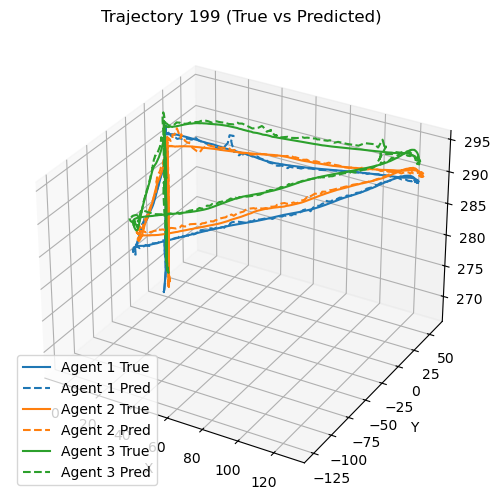

2025-09-17 17:51:47,449 - INFO - Plotted trajectory 199


In [41]:
# --- Group results back by trajectory_index ---
traj_test = traj_test[: len(y_true)]  # align just in case

NUM_PLOTS = 3  # number of trajectories to plot
unique_trajs = np.unique(traj_test)

# Dynamically generate N colors from a colormap
COLORS = [plt.get_cmap("tab10")(i % 10) for i in range(AGENTS)]

# Randomly select trajectories to plot
plot_trajs = np.random.choice(
    unique_trajs, size=min(NUM_PLOTS, len(unique_trajs)), replace=False
)

for traj_idx in plot_trajs:
    mask = traj_test == traj_idx
    true_traj = scaler_y.inverse_transform(y_true[mask].numpy())
    pred_traj = scaler_y.inverse_transform(y_pred[mask].numpy())

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    DIM = 3  # 3D plot
    for agent in range(AGENTS):
        start = agent * DIM
        end = start + DIM

        # True trajectory for this agent
        ax.plot(
            true_traj[:, start],
            true_traj[:, start + 1],
            true_traj[:, start + 2],
            label=f"Agent {agent + 1} True",
            color=COLORS[agent],
        )

        # Predicted trajectory for this agent
        ax.plot(
            pred_traj[:, start],
            pred_traj[:, start + 1],
            pred_traj[:, start + 2],
            label=f"Agent {agent + 1} Pred",
            color=COLORS[agent],
            linestyle="--",
        )

    ax.set_title(f"Trajectory {traj_idx} (True vs Predicted)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_label("Z")
    ax.legend()

    # --- Save PNGs ---
    plot_path = os.path.join(exp_dir, f"trajectory_{traj_idx}.png")
    plt.savefig(plot_path, dpi=150)

    # --- For interactive viewing ---
    plt.show()
    plt.close()

    logger.info("Plotted trajectory %s", traj_idx)